## 单层感知机

### 感知机

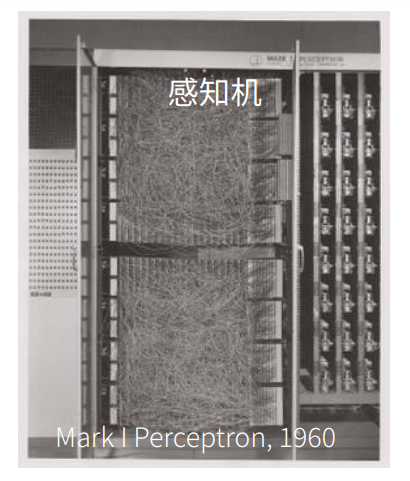
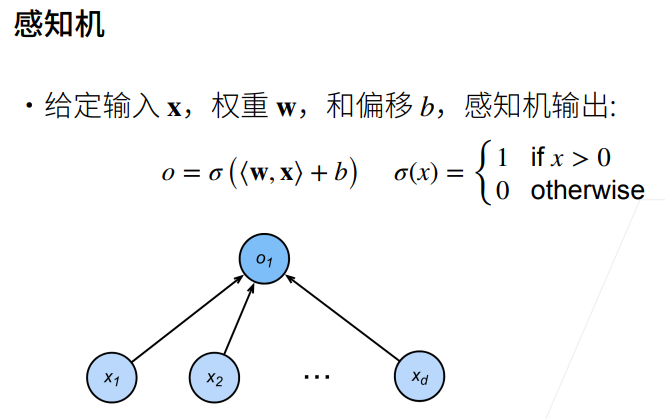

线性回归输出的是一个实数，感知机输出的是一个离散的类。

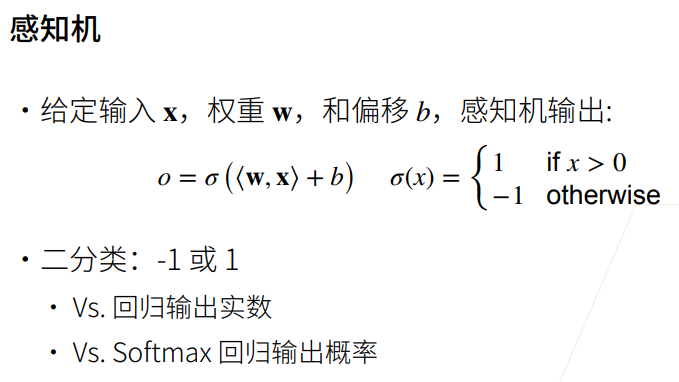

### 训练感知机

① 如果分类正确的话y<w,x>为正数，负号后变为一个负数，max后输出为0，则梯度不进行更新。

② 如果分类错了，y<w,x>为负数，下图中的if判断就成立了，就有梯度进行更新。

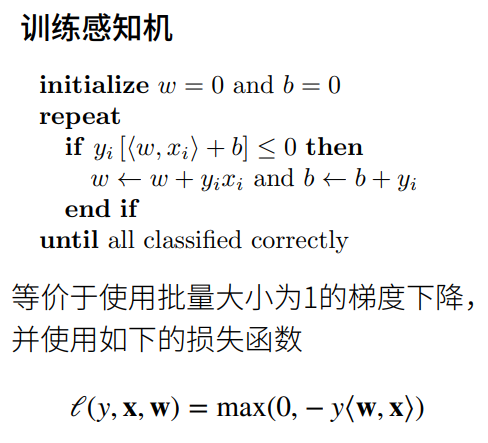
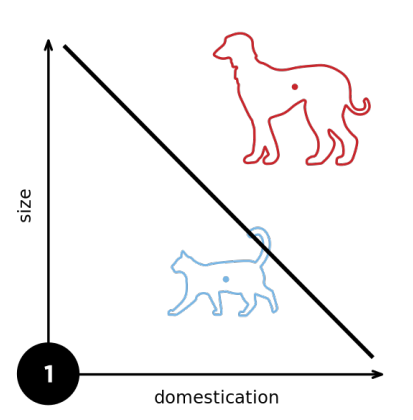
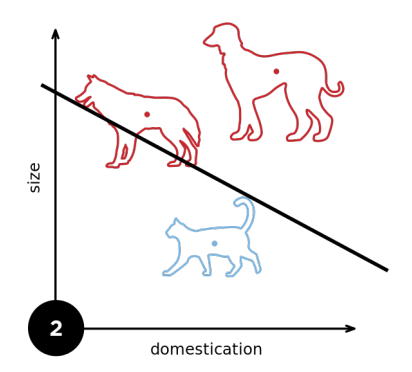
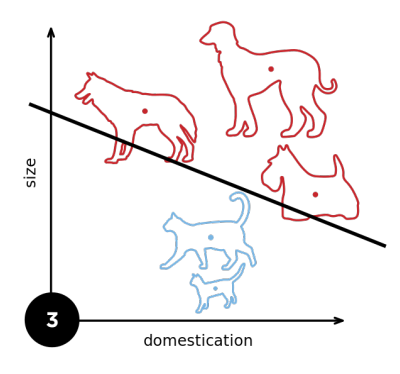
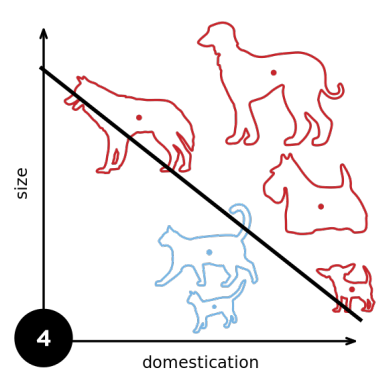

### 收敛半径

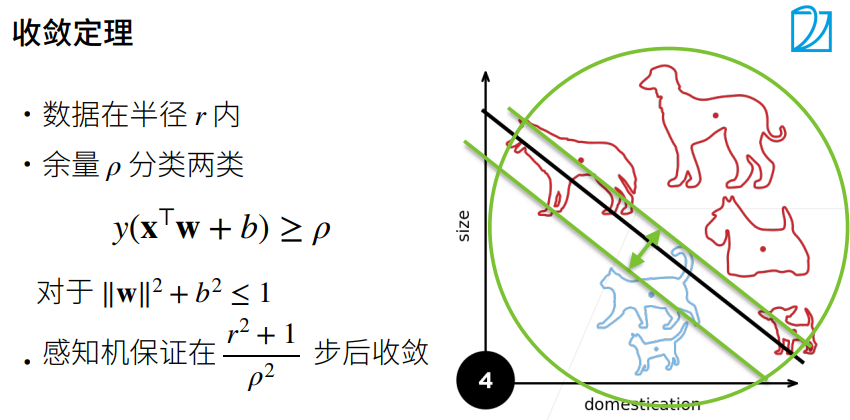

### XOR问题

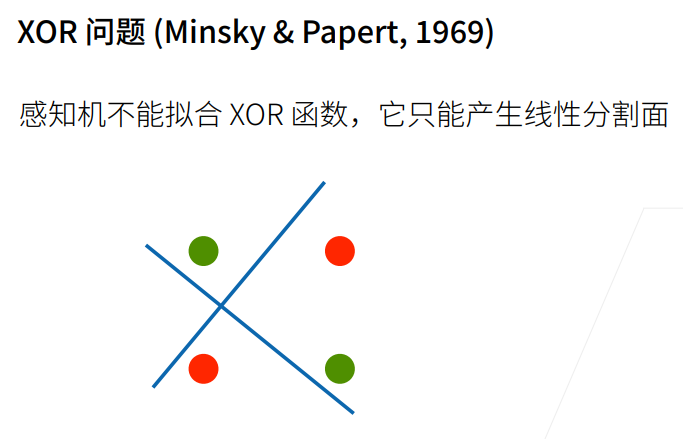

### 总结

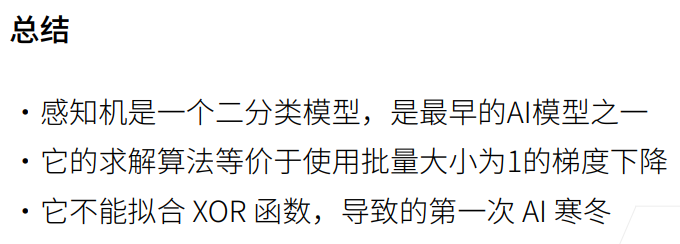

## 多层感知机

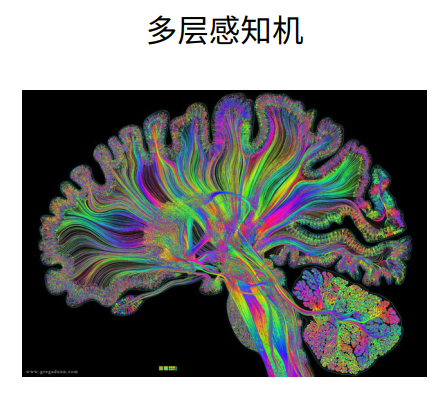

### 学习XOR

① 先用蓝色的线分，再用黄色的线分。

② 再对蓝色的线和黄色的线分出来的结果做乘法。

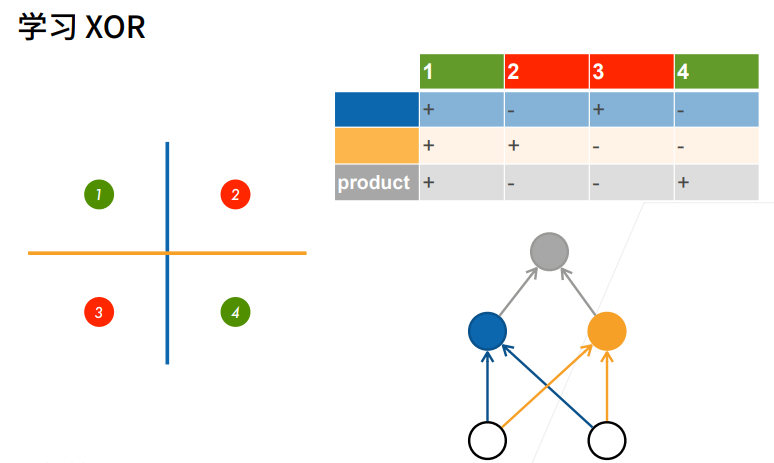

### 单隐藏层

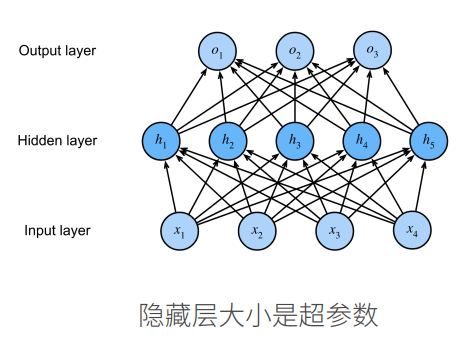
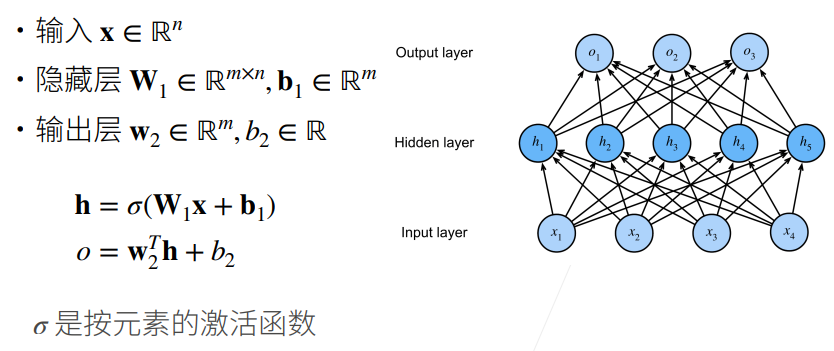
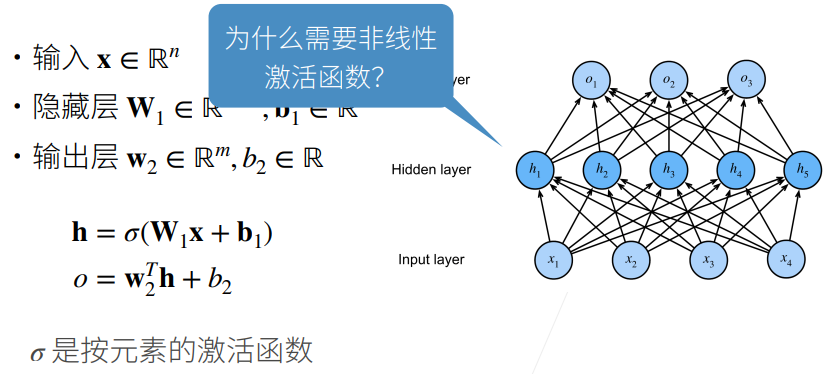

不用激活函数的话，所有全连接层连接在一起依旧可以用一个最简单的线性函数来表示。

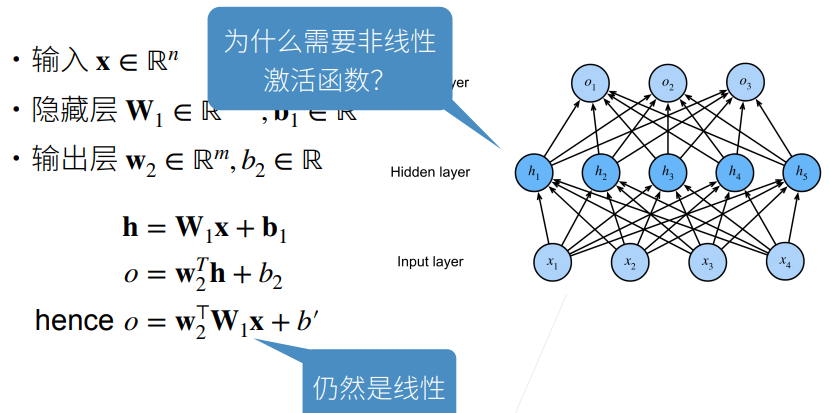

### Sigmoid 函数

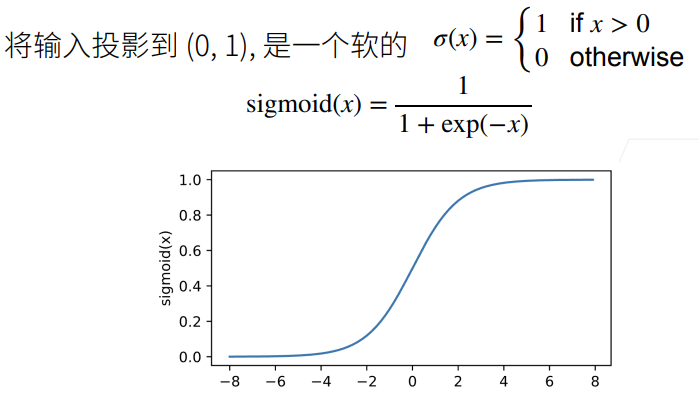

### Tanh函数

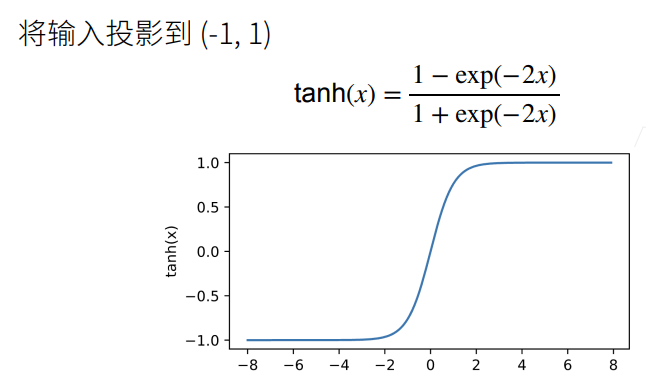

### ReLU

① ReLU的好处在于不需要执行指数运算。

② 在CPU上一次指数运算相当于上百次乘法运算。

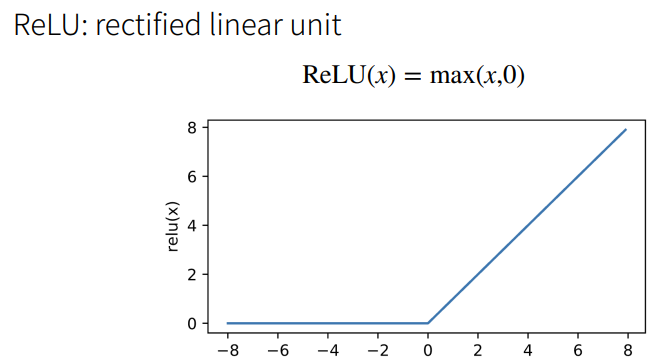

### 多类分类

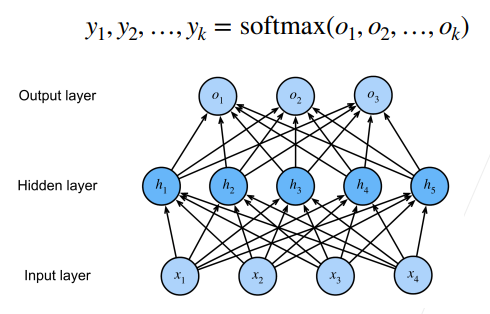
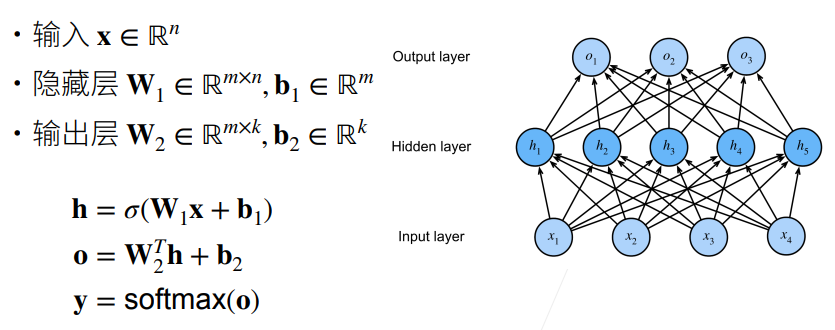
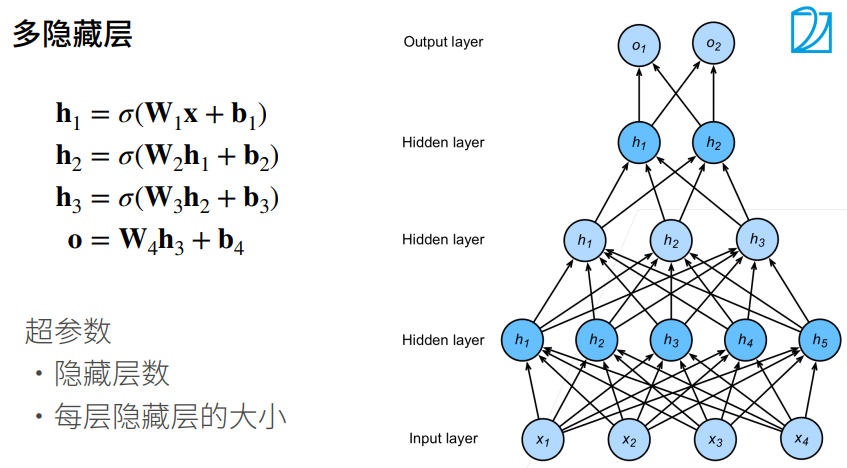

### 总结

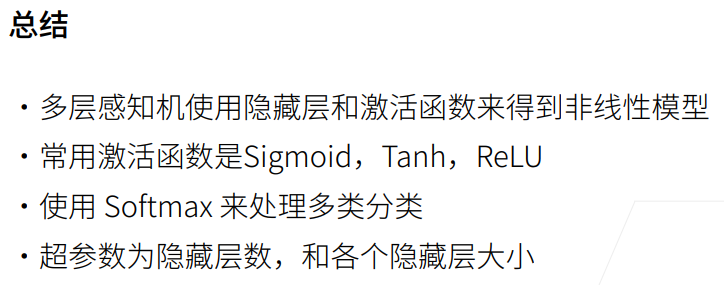

# 多层感知机的从零开始实现

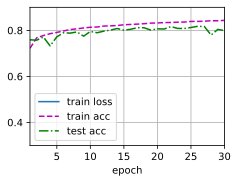

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# 实现一个具有单隐藏层的多层感知机，它包含256个隐藏单元
num_inputs, num_outputs, num_hiddens = 784, 10, 256 # 输入、输出是数据决定的，256是调参自己决定的
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True))
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True))
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1,b1,W2,b2]

# 实现 ReLu 激活函数
def relu(X):
    a = torch.zeros_like(X) # 数据类型、形状都一样，但是值全为 0
    return torch.max(X,a)

# 实现模型
def net(X):
    #print("X.shape:",X.shape)
    X = X.reshape((-1, num_inputs)) # -1为自适应的批量大小
    #print("X.shape:",X.shape)
    H = relu(X @ W1 + b1)
    #print("H.shape:",H.shape)
    #print("W2.shape:",W2.shape)
    return (H @ W2 + b2)

# 损失
loss = nn.CrossEntropyLoss() # 交叉熵损失

# 多层感知机的训练过程与softmax回归的训练过程完全一样
num_epochs ,lr = 30, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

# 多层感知机的简洁实现

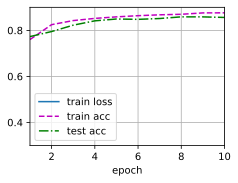

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# 隐藏层包含256个隐藏单元，并使用了ReLU激活函数
net = nn.Sequential(nn.Flatten(), nn.Linear(784,256), nn.ReLU(), nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.1)
        
net.apply(init_weights)

# 训练过程
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 模型选择

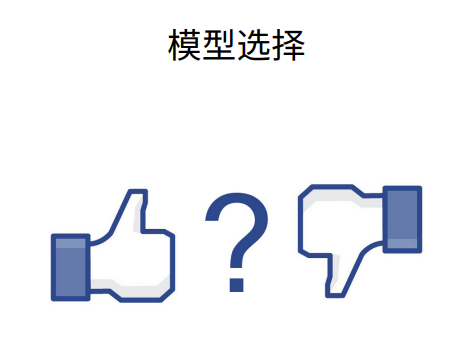
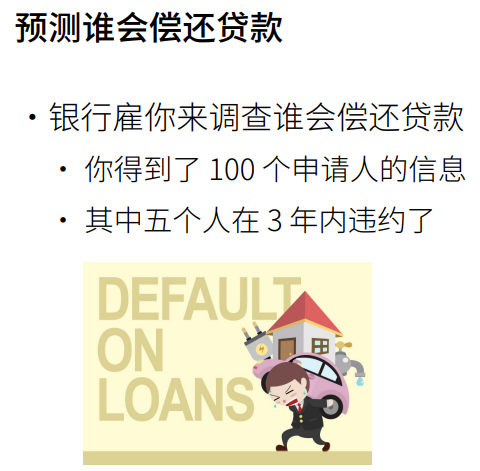
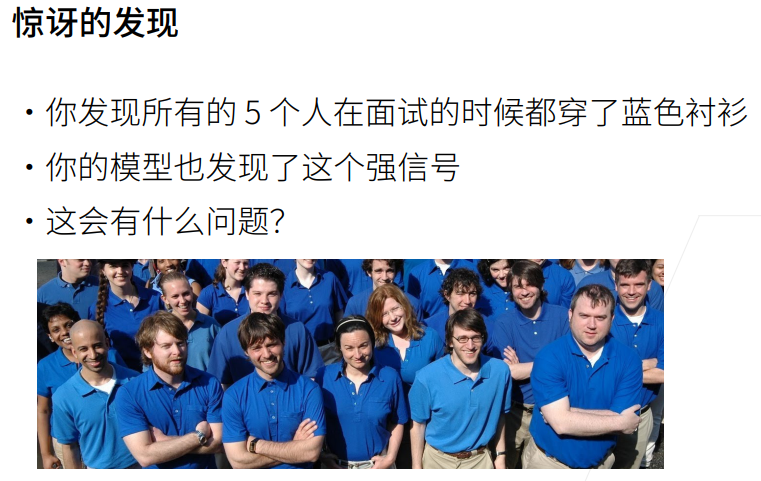
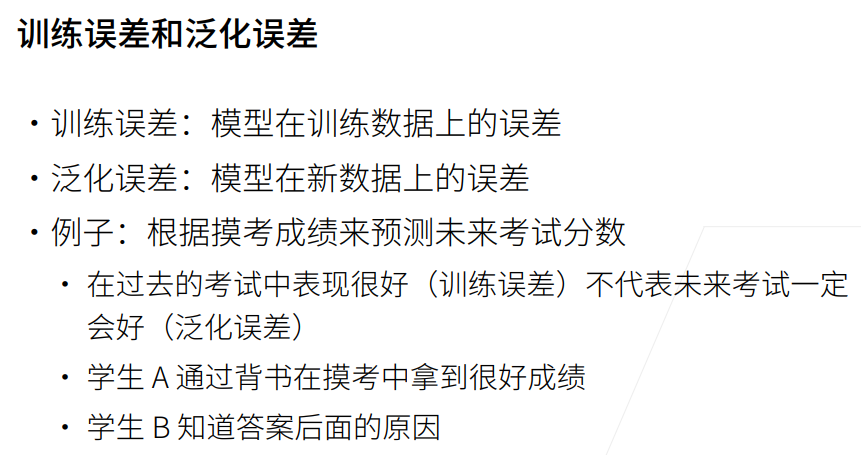
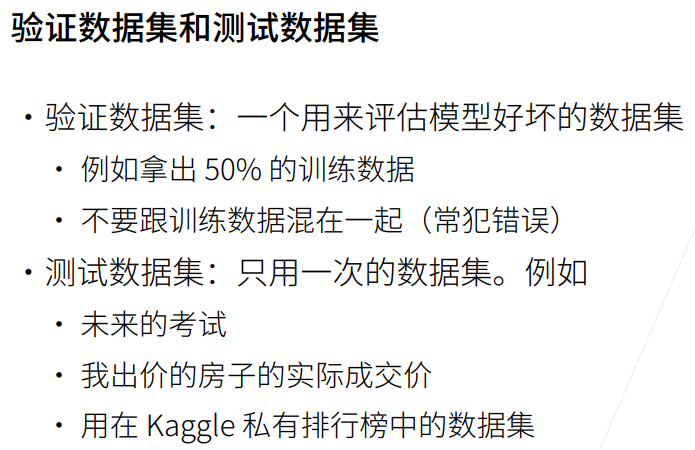
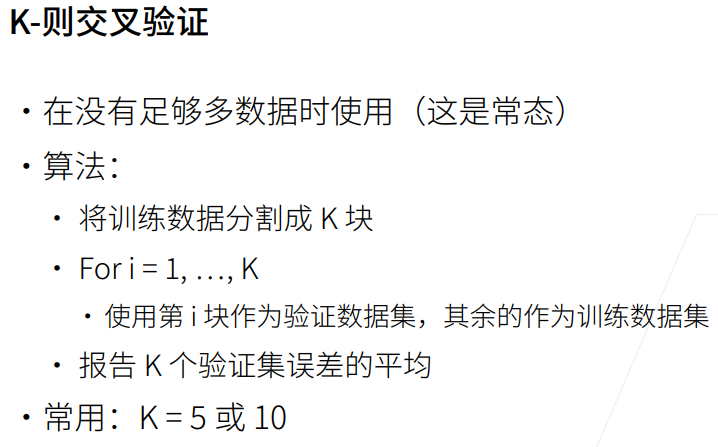
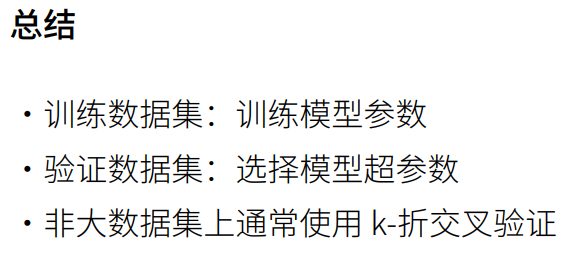

# 过拟合、欠拟合

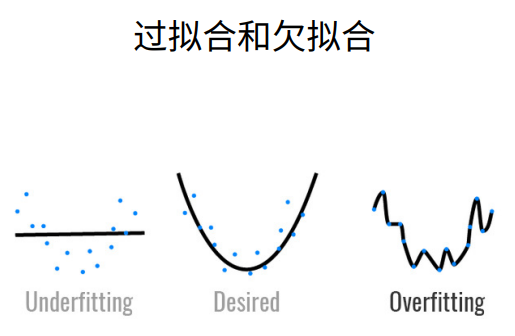
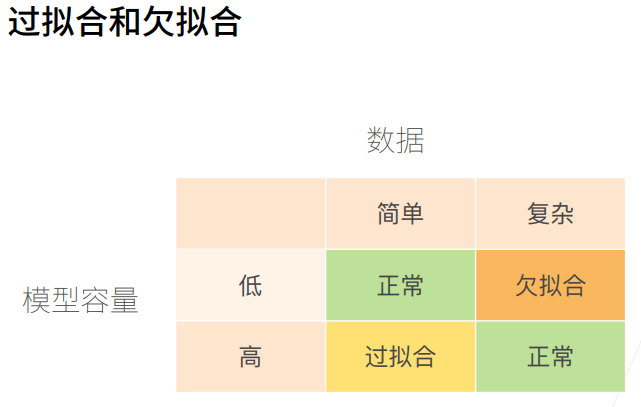
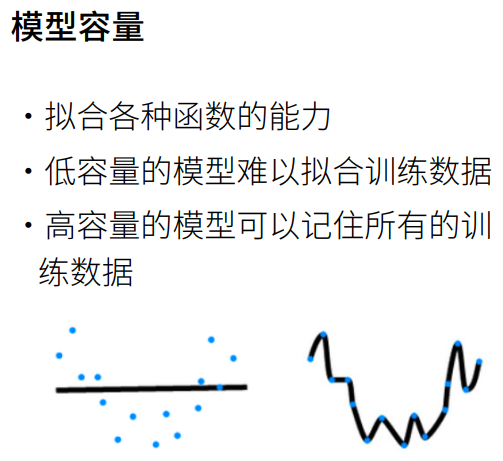

① 在多项式拟合中，模型容量为不同多项式次方。

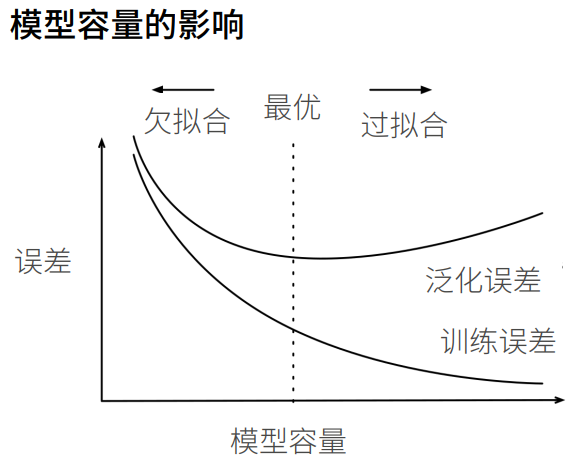
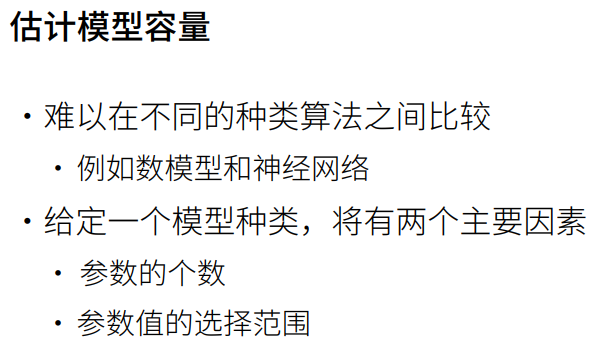

上图是树模型和神经网络，不是数

② d是特征向量的维度，1是偏置b的维度。

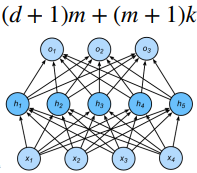
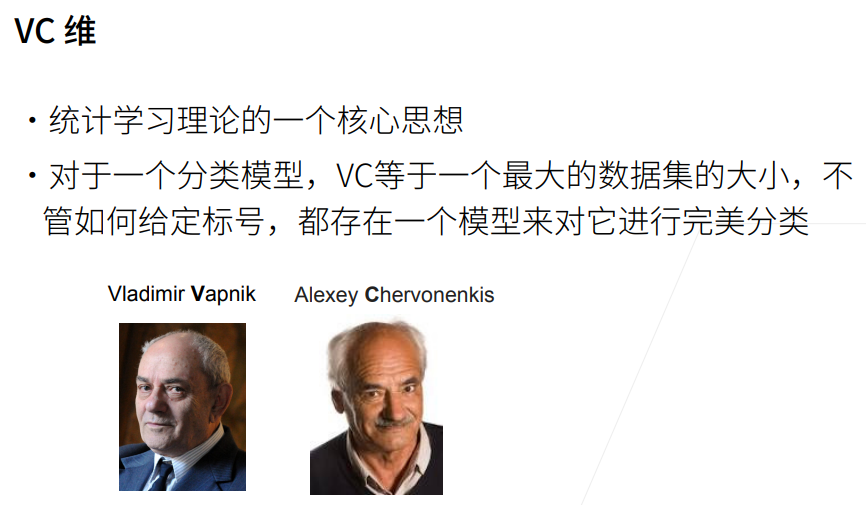
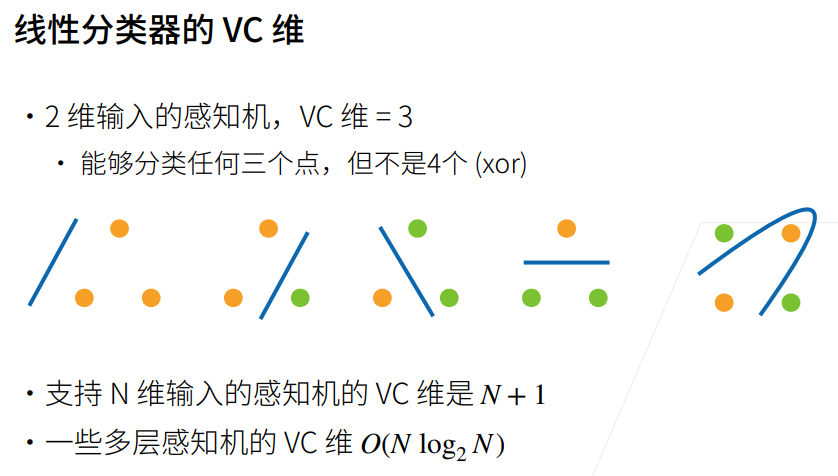
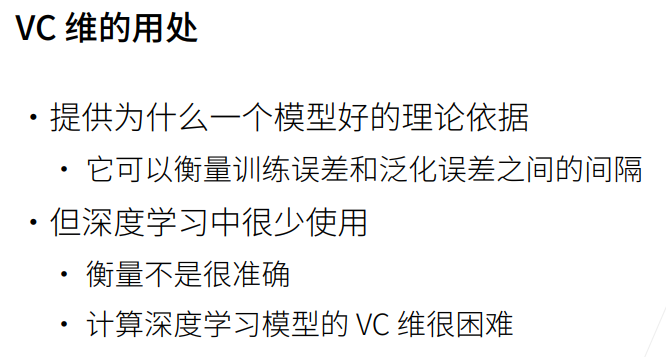
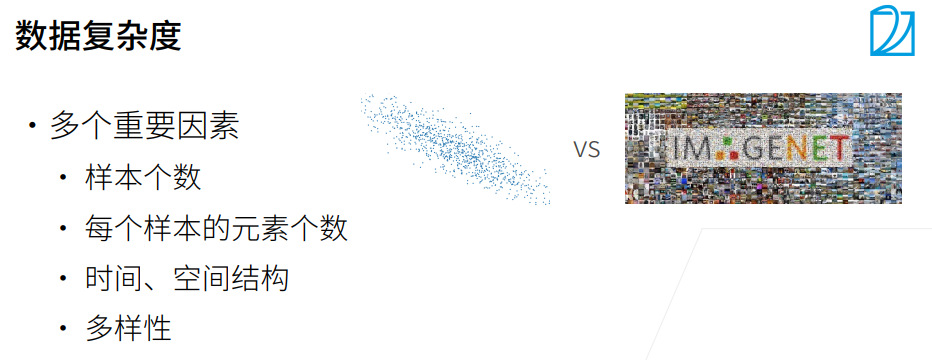
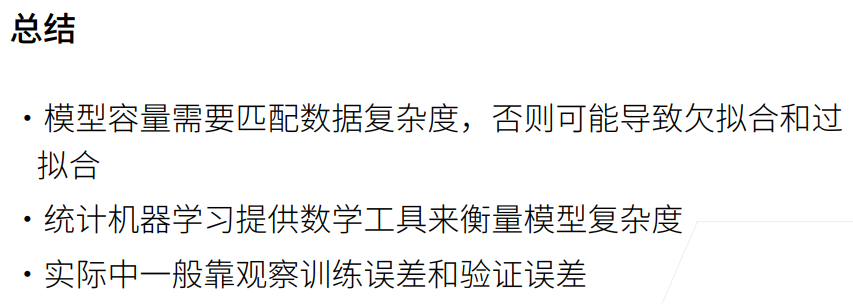

# 多项式解释欠拟合、过拟合

① 使用以下三阶多项式来生成训练和测试数据的标签：$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }\epsilon \sim \mathcal{N}(0, 0.1^2)$$
② 这个式子只是一个三次多项式，并不是哪个函数的泰勒展开。

In [1]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20 # 特征为20就是每一个样本是一个[20,1]的tensor
n_train, n_test = 100, 100 # 100个测试样本、100验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) # 真实标号为5

features = np.random.normal(size=(n_train+n_test,1))
print(features.shape)
np.random.shuffle(features)
print(np.arange(max_degree))
print(np.arange(max_degree).reshape(1,-1))
print(np.power([[10,20]],[[1,2]]))
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) # 对第所有维的特征取0次方、1次方、2次方...19次方  
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # i次方的特征除以(i+1)阶乘
labels = np.dot(poly_features,true_w) # 根据多项式生成y，即生成真实的labels
labels += np.random.normal(scale=0.1,size=labels.shape) # 对真实labels加噪音进去

#看一下前两个样本
true_w, features, poly_features, labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w, features, poly_features, labels]]                 
print(features[:2]) # 前两个样本的x
print(poly_features[:2,:]) # 前两个样本的x的所有次方
print(labels[:2])  # 前两个样本的x对应的y

# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 两个数的累加器
    for X, y in data_iter: # 从迭代器中拿出对应特征和标签
        out = net(X)
        y = y.reshape(out.shape) # 将真实标签改为网络输出标签的形式，统一形式
        l = loss(out, y) # 计算网络输出的预测值与真实值之间的损失差值
        metric.add(l.sum(), l.numel()) # 总量除以个数，等于平均
    return metric[0] / metric[1] # 返回数据集的平均损失

# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 单层线性回归
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)    
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])                   
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net,test_iter,loss)))
    print('weight',net[0].weight.data.numpy()) # 训练完后打印，打印最终学到的weight值  

(200, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
[[ 10 400]]
tensor([[-0.3354],
        [-1.9276]])
tensor([[ 1.0000e+00, -3.3542e-01,  5.6254e-02, -6.2896e-03,  5.2742e-04,
         -3.5381e-05,  1.9779e-06, -9.4778e-08,  3.9738e-09, -1.4810e-10,
          4.9676e-12, -1.5148e-13,  4.2341e-15, -1.0925e-16,  2.6174e-18,
         -5.8528e-20,  1.2270e-21, -2.4209e-23,  4.5113e-25, -7.9641e-27],
        [ 1.0000e+00, -1.9276e+00,  1.8579e+00, -1.1938e+00,  5.7530e-01,
         -2.2179e-01,  7.1256e-02, -1.9622e-02,  4.7281e-03, -1.0127e-03,
          1.9521e-04, -3.4208e-05,  5.4950e-06, -8.1480e-07,  1.1219e-07,
         -1.4417e-08,  1.7370e-09, -1.9695e-10,  2.1092e-11, -2.1399e-12]])
tensor([  4.2881, -10.4517])


weight [[ 4.989716   1.2031109 -3.4016833  5.6160975]]


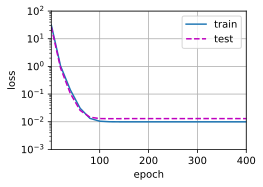

In [2]:
# 三阶多项式函数拟合(正态)
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])  # 最后返回的weight值和公式真实weight值很接近

weight [[3.0190358 4.847456 ]]


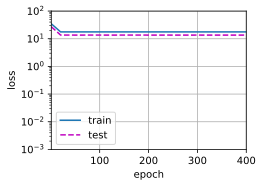

In [3]:
# 一阶多项式函数拟合(欠拟合)
# 这里相当于用一阶多项式拟合真实的三阶多项式，欠拟合了，损失很高，根本就没降
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight [[ 4.9736595   1.4366992  -3.3356755   4.752965   -0.2380412   1.475293
   0.27963173  0.2533025   0.13136809 -0.1458123   0.11464729  0.0701267
  -0.21083154  0.1514295  -0.03916414  0.13507093  0.18277296 -0.10127922
   0.0637595  -0.19785832]]


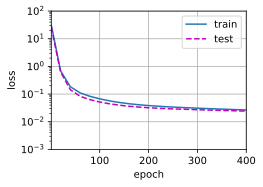

In [4]:
# 十九阶多项式函数拟合(过拟合)
# 这里相当于用十九阶多项式拟合真实的三阶多项式，过拟合了
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])

# 权重衰退

① 权重衰退是常见的处理过拟合的一种方法。

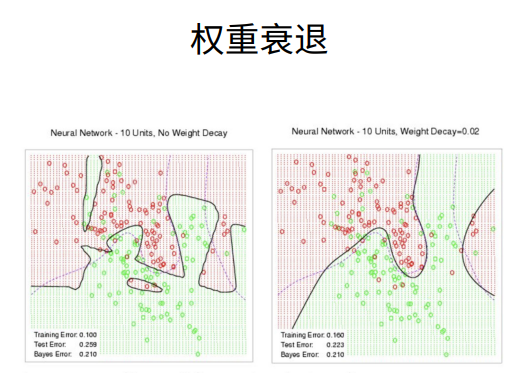

② 把模型容量控制比较小有两种方法，方法一：模型控制的比较小，使得模型中参数比较少。方法二：控制参数选择范围来控制参数容量。

③ 如下图所示，w向量中每一个元素的值都小于θ的根号。

④ 约束就是正则项。每个特征的权重都大会导致模型复杂，从而导致过拟合。控制权重矩阵范数可以使得减少一些特征的权重，甚至使他们权重为0，从而导致模型简单，减轻过拟合。

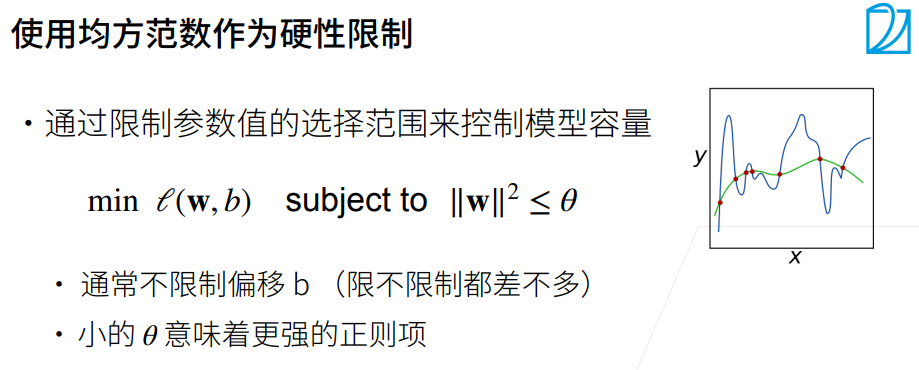

⑤ λ是一个平滑的，不像以前的硬性限制。

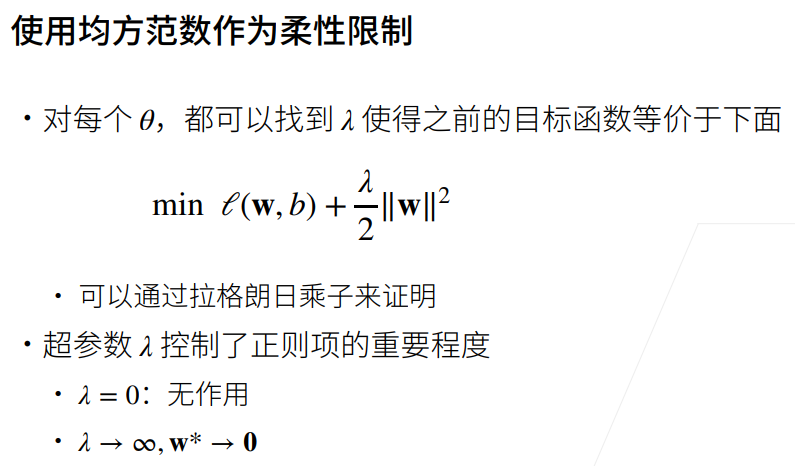

⑥ 拉格朗日乘子法原本是用于解决约束条件下的多元函数极值问题。举例，求f(x,y)的最小值，但是有约束C(x,y) = 0。乘子法给的一般思路是，构造一个新的函数g(x,y,λ) = f(x,y) +λC(x,y)，当同时满足g'x = g'y = 0时，函数取到最小值。这件结论的几何含义是，当f(x,y)与C(x,y)的等高线相切时，取到最小值。

⑦ 具体到机器学习这里，C(x,y) = w^2 -θ。所以图中的黄色圆圈，代表不同θ下的约束条件。θ越小，则最终的parameter离原点越近。

① 绿色的线就是原始损失函数l的等高线，优化原始损失l的最优解(波浪号即最优解)在中心位置。

② 当原始损失加入二分之λ的项后，这个项是一个二次项，假如w就两个值，x1(横轴)、x2(纵轴)，那么在图上这个二次项的损失以原点为中心的等高线为橙色的图所示。所以合并后的损失为绿色的和黄色的线加一起的损失。

③ 当加上损失项后，可以知道原来最优解对应的二次项的损失特别大，因此原来的最优解不是加上二次项后的公式的最优解了。若沿着橙色的方向走，原有l损失值会大一些，但是二次项罚的损失会变小，当拉到平衡点以内时，惩罚项减少的值不足以弥补l损失增大的值，这样w*就是加惩罚项后的最优解。

④ 损失函数加上正则项成为目标函数，目标函数最优解不是损失函数最优解。正则项就是防止达到损失函数最优导致过拟合，把损失函数最优点往外拉一拉。鼓励权重分散，将所有的特征运用起来，而不是依赖其中的少数特征，并且权重分散的话它的内积就小一些。

⑤ l2正则项会对大数值的权值进行惩罚。

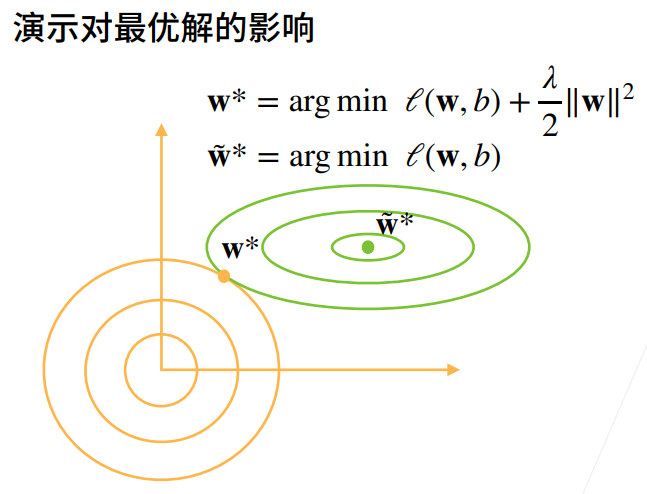

相对原来的权重更新，再减去一个值后，使得这个权重更进一步减小，这样会导致这个权重所占的比例进一步减小。

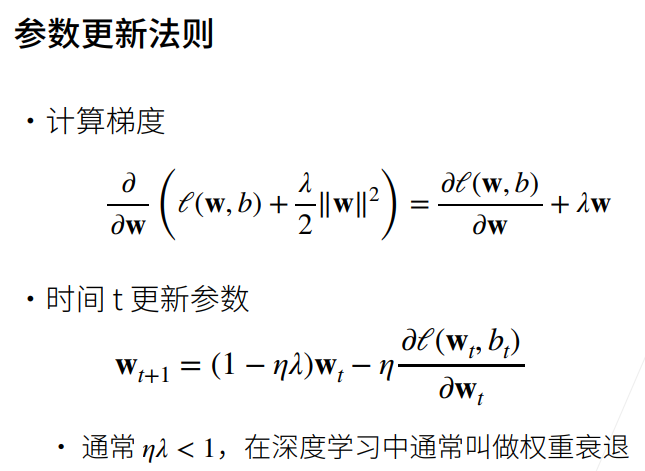
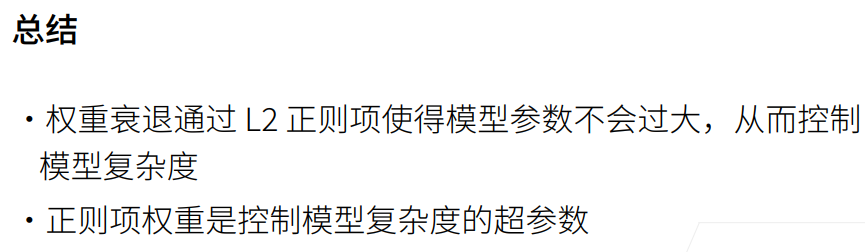

# 权重衰退（使用自定义）

① 权重衰退是最广泛使用的正则化的技术之一。

② 像以前一样生成一些数据：$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5 # 数据越简单，模型越复杂，越容易过拟合。num_inputs为特征维度
true_w, true_b = torch.ones((num_inputs,1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 生成人工数据集
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# 初始化模型参数
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b = torch.zeros(1,requires_grad=True)
    return [w,b]

# 定义L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# 定义训练函数
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])                   
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #with torch.enable_grad():
            l = loss(net(X),y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w,b],lr,batch_size)
        if(epoch+1) % 5 == 0:
            if(epoch+1) % 5 ==0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是',torch.norm(w).item()) 

In [2]:
help(d2l.synthetic_data) # 查看函数用法

Help on function synthetic_data in module d2l.torch:

synthetic_data(w, b, num_examples)
    Generate y = Xw + b + noise.
    
    Defined in :numref:`sec_linear_scratch`



w的L2范数是 13.881475448608398


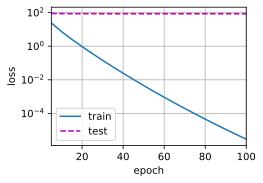

In [3]:
# 忽略正则化直接训练
train(lambd=0)  # 训练集小，过拟合，测试集损失不下降

w的L2范数是 0.3627158999443054


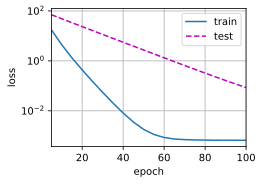

In [4]:
# 使用权重衰退
train(lambd=3)

# 权重衰退（使用框架）

In [5]:
# 简洁实现
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{"params":net[0].weight,"weight_decay":wd},{"params":net[0].bias}],lr=lr) # 惩罚项既可以写在目标函数里面，也可以写在训练算法里面，每一次在更新之前把当前的w乘以衰退因子weight_decay                     
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[5,num_epochs],legend=['train','test'])                   
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X),y)
            l.backward()
            trainer.step()
            if(epoch + 1) % 5 == 0:
                animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net,test_iter,loss)))
    print('w的L2范数是',net[0].weight.norm().item()) 

w的L2范数是 12.98708724975586


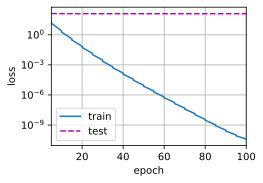

In [6]:
# 这些图看起来和我们从零开始实现权重衰减时的图相同
train_concise(0)

w的L2范数是 0.4080813229084015


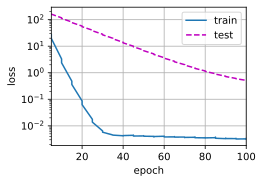

In [7]:
train_concise(3)

# 丢弃法

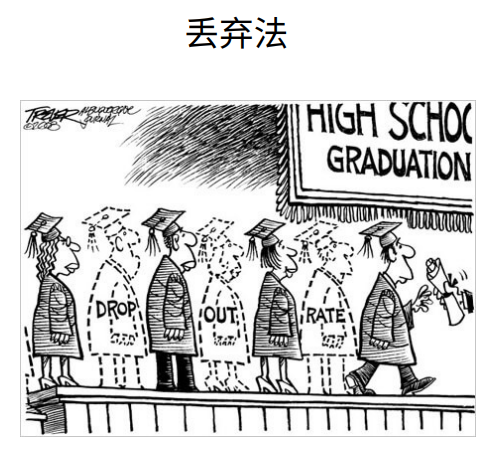
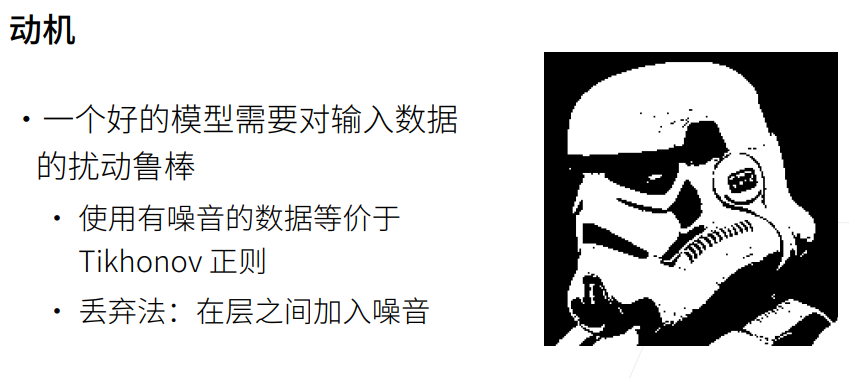

这里除以1-p是为了$x_{i}^{‘}$与原来的$x_{i}$的期望相同。

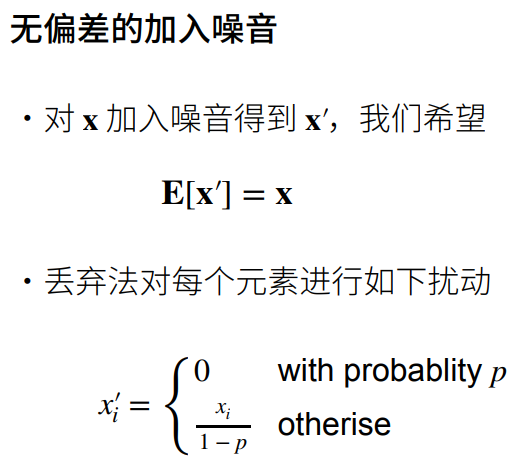
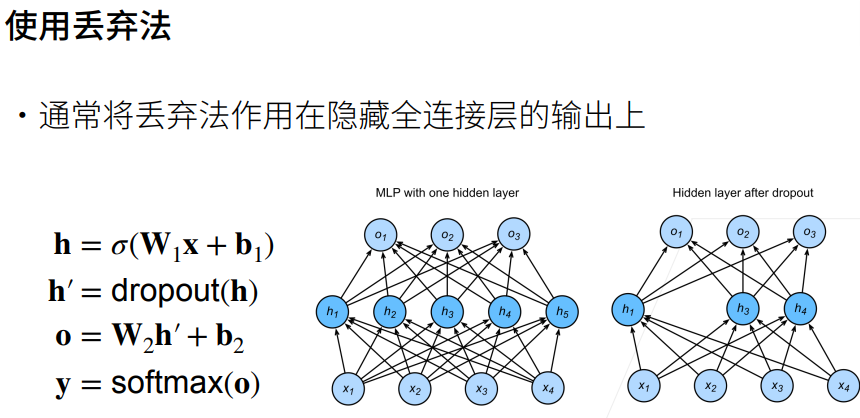
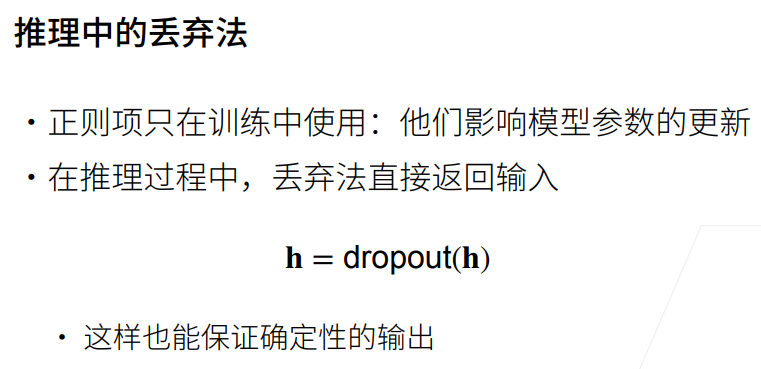
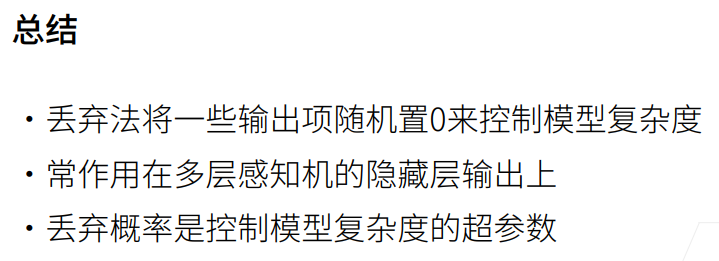

# 丢弃法（使用自定义）

In [1]:
# 实现dropout_layer函数，该函数以dropout的概率丢弃张量输入x中的元素
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1 # dropout大于等于0，小于等于1，否则报错
    if dropout == 1:
        return torch.zeros_like(X) # 如果dropout为1，则X返回为全0
    if dropout == 0:
        return X # 如果dropout为1，则X返回为全原值
    mask = (torch.randn(X.shape)>dropout).float() # 取X.shape里面0到1之间的均匀分布，如果值大于dropout，则把它选出来
    #print((torch.randn(X.shape)>dropout)) # 返回的是布尔值，然后转布尔值为0、1
    return mask * X / (1.0 - dropout) 

X = torch.arange(16,dtype=torch.float32).reshape((2,8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5)) # 有百分之50的概率变为0
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  0.,  6.,  8.,  0.,  0., 14.],
        [ 0., 18., 20., 22.,  0., 26.,  0.,  0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [2]:
# 由于在前面的学习发现train_ch3在绘制loss曲线时有问题，所以自己定义训练函数
def my_train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer):
    """手动实现的训练和绘图函数"""
    train_loss, train_acc, test_acc = [], [], []
    
    for epoch in range(num_epochs):
        # 训练一个周期，并计算训练损失和精度
        epoch_loss, epoch_train_acc = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        # 在测试集上评估精度
        epoch_test_acc = d2l.evaluate_accuracy(net, test_iter)
        
        # 记录数据
        train_loss.append(epoch_loss)
        train_acc.append(epoch_train_acc)
        test_acc.append(epoch_test_acc)
        
        # 打印日志
        print(f'Epoch {epoch+1}: loss {epoch_loss:.3f}, train acc {epoch_train_acc:.3f}, test acc {epoch_test_acc:.3f}')
    
    # 训练结束后，统一绘制图表
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 绘制精度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r-', label='Train Acc')
    plt.plot(epochs, test_acc, 'g--', label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1: loss 0.004, train acc 0.590, test acc 0.714
Epoch 2: loss 0.003, train acc 0.761, test acc 0.769
Epoch 3: loss 0.002, train acc 0.796, test acc 0.823
Epoch 4: loss 0.002, train acc 0.814, test acc 0.821
Epoch 5: loss 0.002, train acc 0.822, test acc 0.827
Epoch 6: loss 0.002, train acc 0.831, test acc 0.814
Epoch 7: loss 0.002, train acc 0.837, test acc 0.831
Epoch 8: loss 0.002, train acc 0.840, test acc 0.823
Epoch 9: loss 0.002, train acc 0.844, test acc 0.841
Epoch 10: loss 0.002, train acc 0.846, test acc 0.854


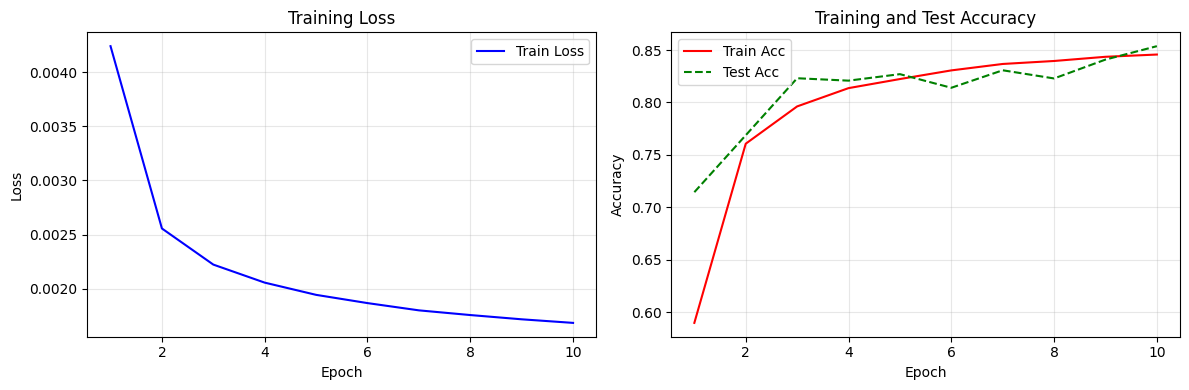

In [3]:
# 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10 ,256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,is_training=True):       
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1,self.num_inputs))))
        if self.training == True: # 如果是在训练，则作用dropout，否则则不作用
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            H2 = dropout_layer(H2,dropout2)
        out = self.lin3(H2) # 输出层不作用dropout
        return out
        
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

# 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr=lr)
my_train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

# 丢弃法（使用框架）

Epoch 1: loss 0.005, train acc 0.536, test acc 0.761
Epoch 2: loss 0.002, train acc 0.781, test acc 0.790
Epoch 3: loss 0.002, train acc 0.821, test acc 0.833
Epoch 4: loss 0.002, train acc 0.834, test acc 0.784
Epoch 5: loss 0.002, train acc 0.844, test acc 0.820
Epoch 6: loss 0.002, train acc 0.855, test acc 0.850
Epoch 7: loss 0.002, train acc 0.859, test acc 0.838
Epoch 8: loss 0.001, train acc 0.863, test acc 0.849
Epoch 9: loss 0.001, train acc 0.870, test acc 0.829
Epoch 10: loss 0.001, train acc 0.872, test acc 0.848


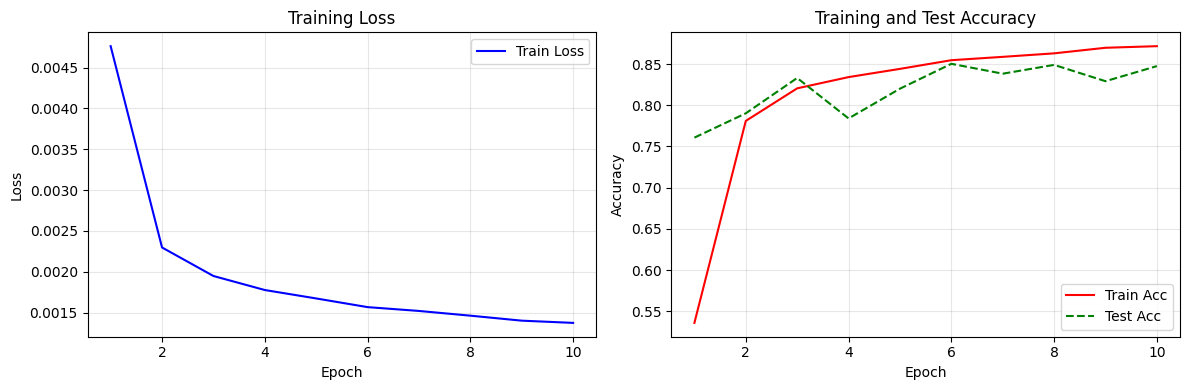

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

# 简洁实现
num_epochs, lr, batch_size = 10, 0.5, 256
dropout1, dropout2 = 0.2, 0.5
loss = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(),nn.Linear(784,256),nn.ReLU(),
                   nn.Dropout(dropout1),nn.Linear(256,256),nn.ReLU(),
                   nn.Dropout(dropout2),nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
    
net.apply(init_weights)

def my_train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer):
    """手动实现的训练和绘图函数"""
    train_loss, train_acc, test_acc = [], [], []
    
    for epoch in range(num_epochs):
        # 训练一个周期，并计算训练损失和精度
        epoch_loss, epoch_train_acc = d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        # 在测试集上评估精度
        epoch_test_acc = d2l.evaluate_accuracy(net, test_iter)
        
        # 记录数据
        train_loss.append(epoch_loss)
        train_acc.append(epoch_train_acc)
        test_acc.append(epoch_test_acc)
        
        # 打印日志
        print(f'Epoch {epoch+1}: loss {epoch_loss:.3f}, train acc {epoch_train_acc:.3f}, test acc {epoch_test_acc:.3f}')
    
    # 训练结束后，统一绘制图表
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12, 4))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 绘制精度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'r-', label='Train Acc')
    plt.plot(epochs, test_acc, 'g--', label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

trainer = torch.optim.SGD(net.parameters(),lr=lr)
my_train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 数值稳定性

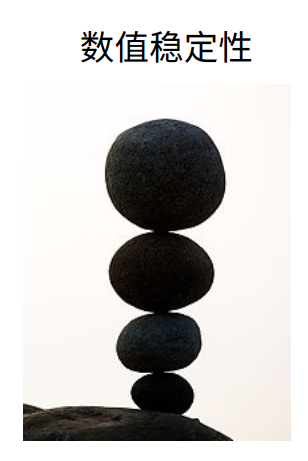
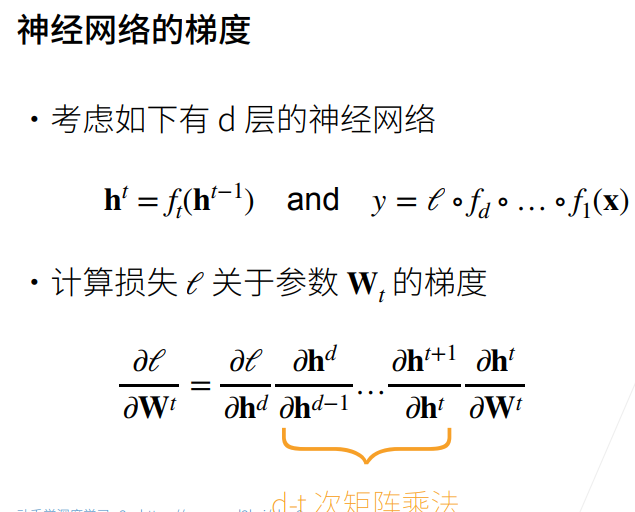
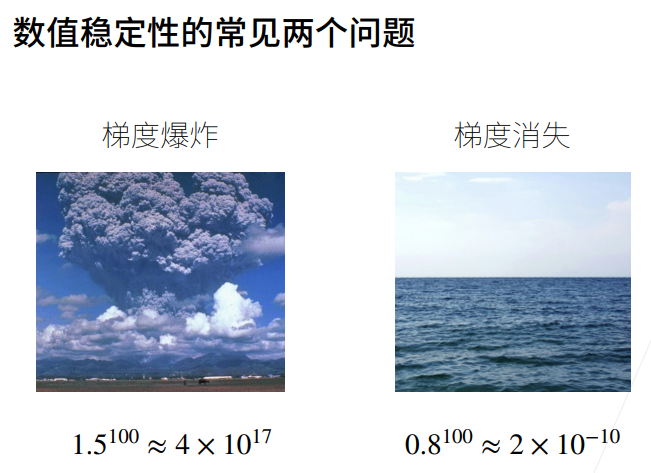

① MLP：多层感知机。

② 对角矩阵(diagonal matrix)是一个主对角线之外的元素皆为0的矩阵，常写为diag(a1, a2, ..., an)。

③ diag*W把diag和W分开看。这就是个链式求导，diag是n维度的relu向量对n维度relu的输入的求导，向量对自身求导就是对角矩阵。

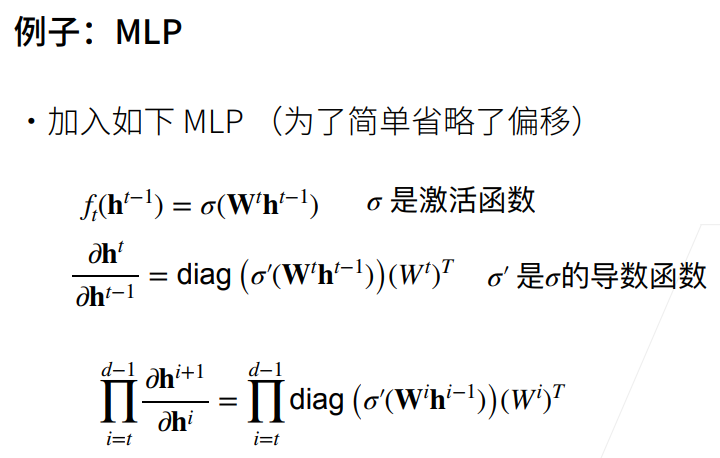

# 梯度爆炸

当W元素值大于1时，层数很深时，连乘会导致梯度爆炸。

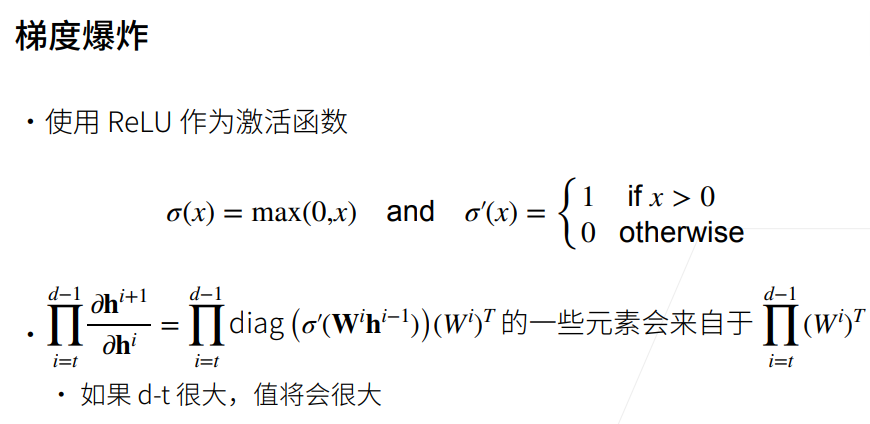
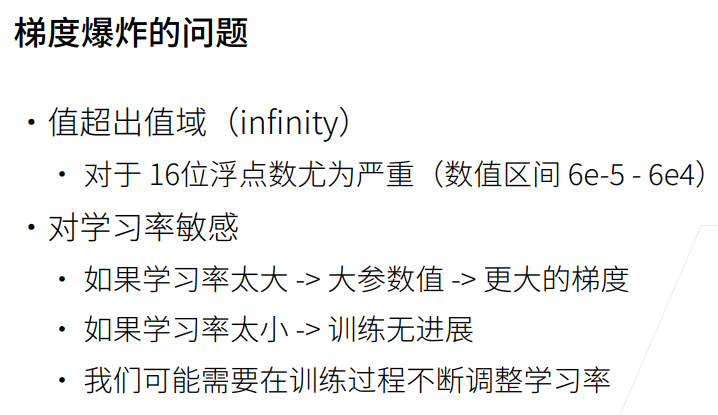

# 梯度消失

① 蓝色为原函数，黄色为梯度函数。

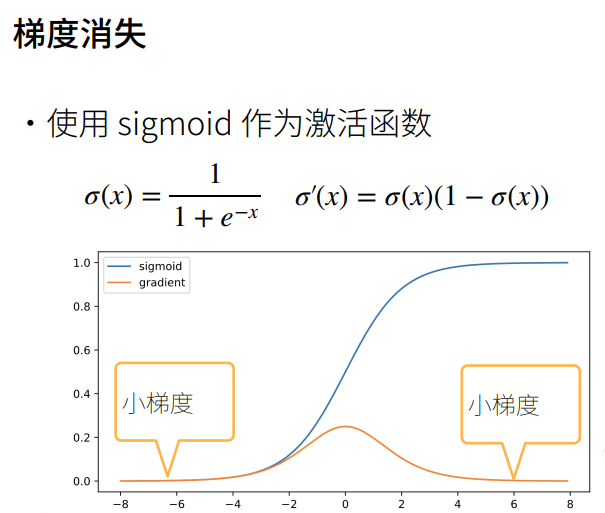

② 当激活函数的输入稍微大一点时，它的导数就变为接近0，连续n个接近0的数相乘，最后的梯度就接近0，梯度就消失了。

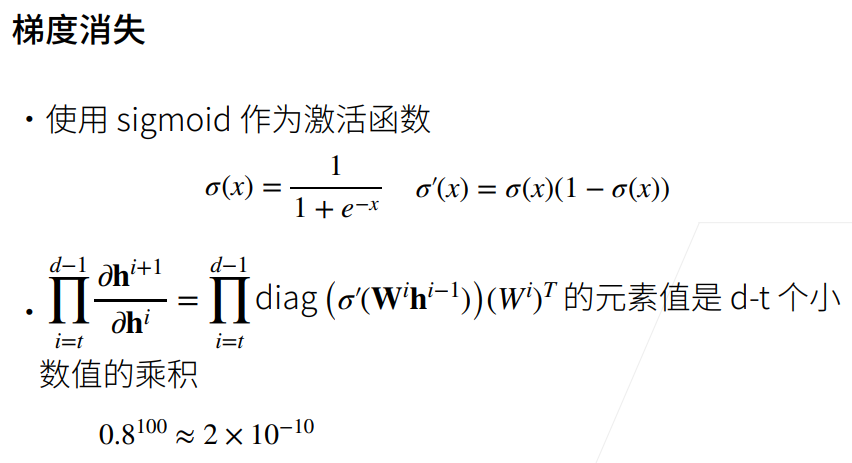
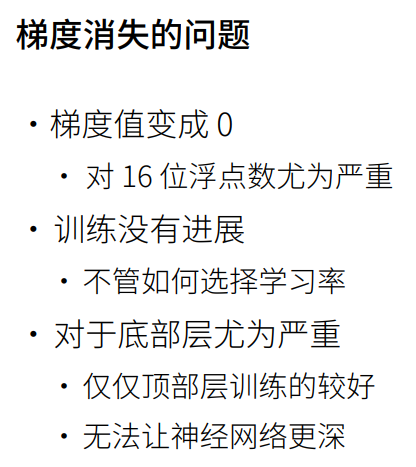

# 总结

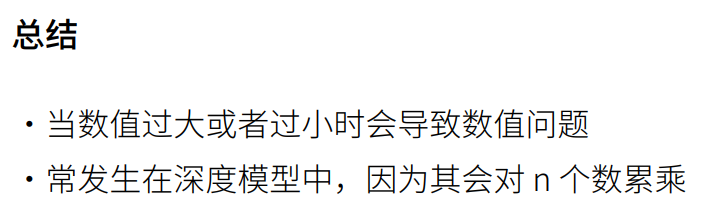

# 训练更稳定

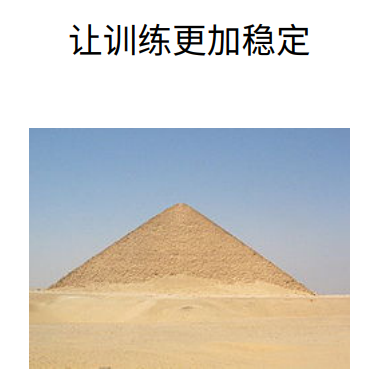
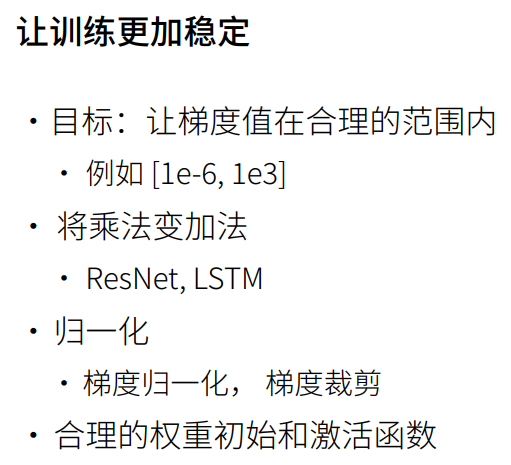
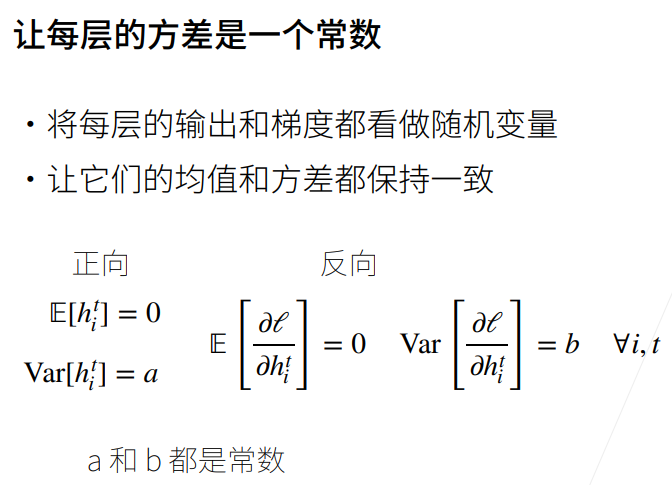
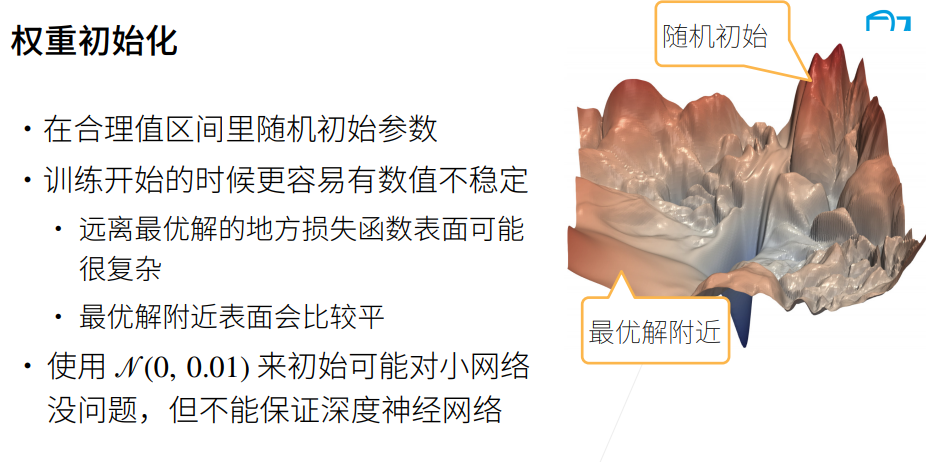

① 假设权重是独立的同分布，均值为0。

② 假设输入与权重是相互独立的。

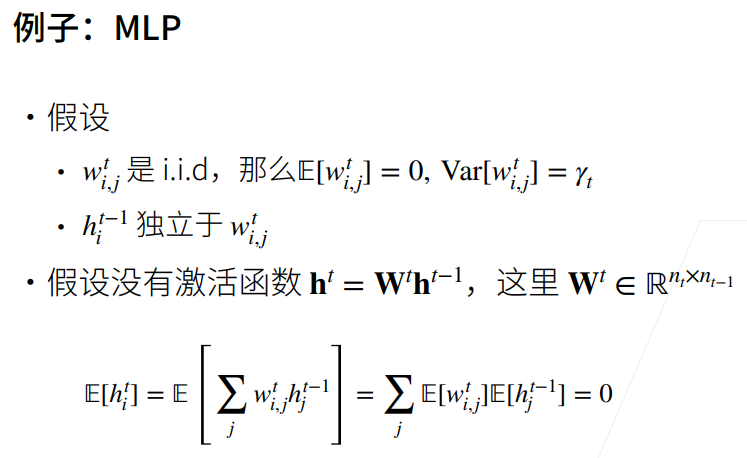
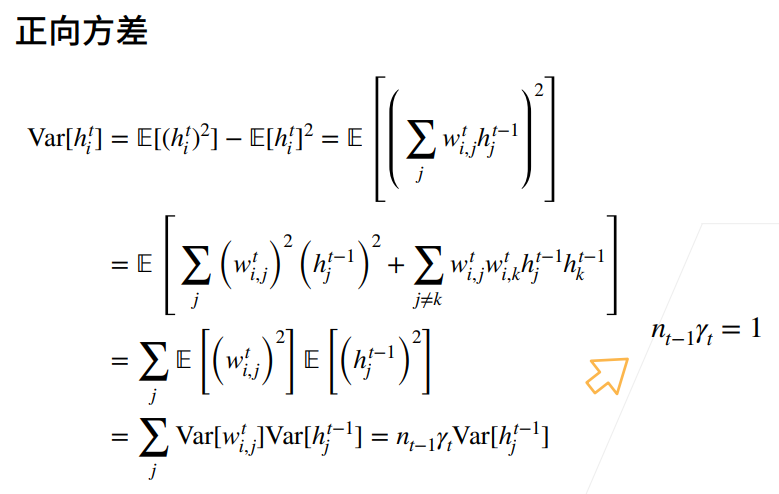
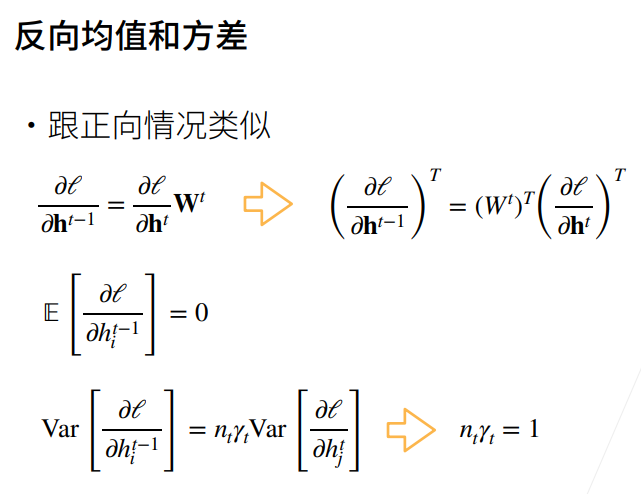
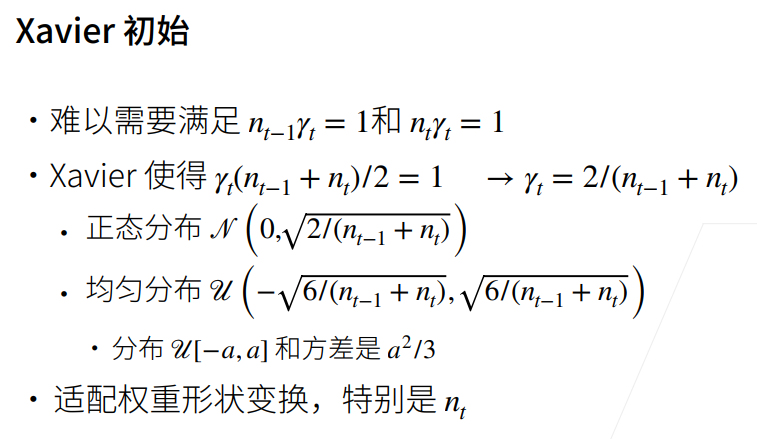
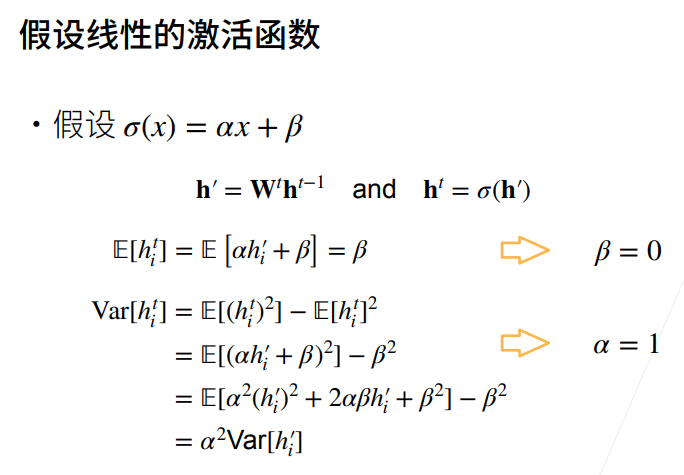
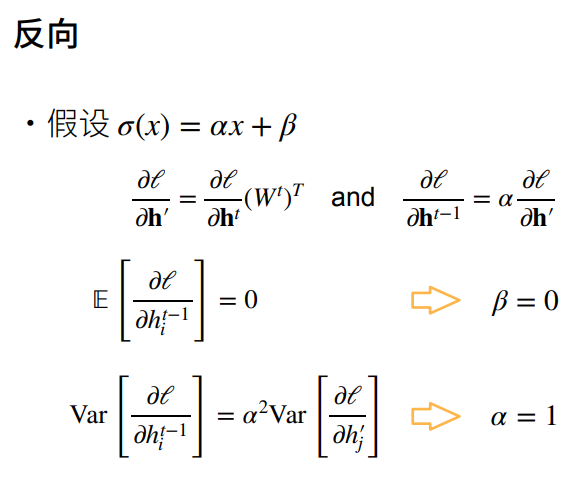
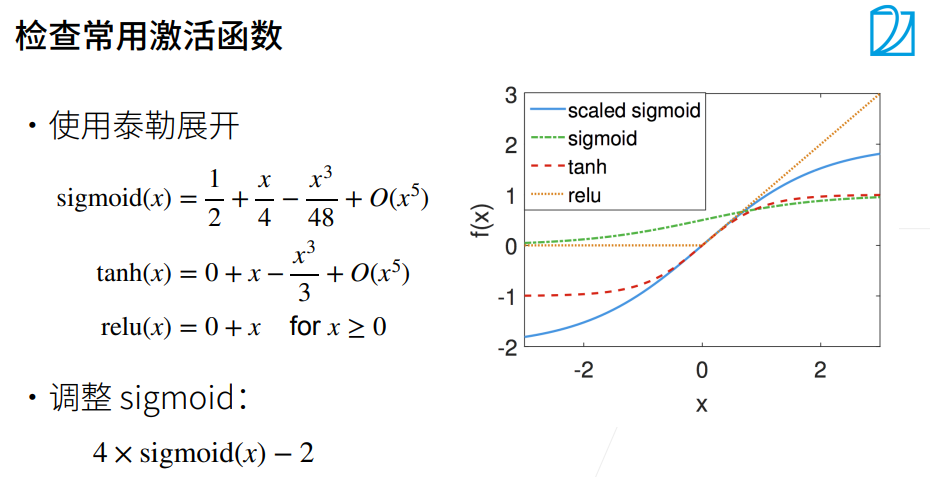

# 总结

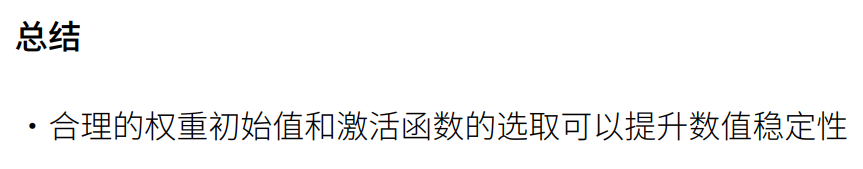

# Kaggle房价预测竞赛

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data/Kaggle_House')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url , sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname
    
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp,extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_UHB中的所有文件"""
    for name in DATA_HUB:
        download(name)

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv','585e9cc9370b9160e7921475fbcd7d31219ce')         
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv', 'fal9780a7b011d9b009e8bff8e99922a8ee2eb90')     
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
print(train_data.shape) # 1460个样本，80个te特征，1个标号label
print(test_data.shape) # 测试样本没有标号label

print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]) # 前面四行的某些列特征

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载..\data/Kaggle_House\kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载..\data/Kaggle_House\kaggle_house_pred_test.csv...
(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [2]:
# 在每个样本中，第一个特征是ID，将其从数据集中删除  
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:])) # 从第2列开始，第1列没有了 
print(all_features.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


In [3]:
# 将所有缺失的值替换成相应特征的平均值
# 通过将特征重新缩放到零均值和单位方差来标准化数据
print(all_features.dtypes) # 可以知道每一列分别为什么类型特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 当值的类型不是object的话，就是一个数值
print(numeric_features)
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 对数值数据变为总体为均值为0，方差为1的分布的数据        
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 将数值数据中not number的数据用0填充

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [4]:
# 处理离散值。用一次独热编码替换它们
# 若一列里面有五个不同的值，则创建五个features，如果该列中为该feature则为1，不为该feature则为0
all_features = pd.get_dummies(all_features,dummy_na=True) 
all_features.shape

(2919, 331)

In [5]:
# 从pandas格式中提取Numpy格式，并将其转换为张量表示
print(train_data.shape)
n_train = train_data.shape[0] # 样本个数
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
# train_data的SalePrice列是label值
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),
                            dtype=torch.float32)

(1460, 81)


In [6]:
# 训练
loss = nn.MSELoss()
print(train_features.shape[1]) # 所有特征个数
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1)) # 单层线性回归
    return net

331


① 我们更关心相对误差$\frac{y - \hat{y}}{y}$，解决这个问题的一种方法是用价格预测的对数来衡量差异。

② 100万的房子，预测与真实值相差5万，10万的房子，预测与真实值相差5万，是不一样的。

In [7]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features),1,float('inf')) # 把模型输出的值限制在1和inf之间，inf代表无穷大（infinity的缩写）       
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels))) # 预测做log，label做log，然后丢到MSE损失函数里
    return rmse.item()

In [8]:
# 训练函数将借助Adam优化器
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [9]:
# K折交叉验证
def get_k_fold_data(k,i,X,y): # 给定k折，给定第几折，返回相应的训练集、测试集
    assert k > 1
    fold_size = X.shape[0] // k  # 每一折的大小为样本数除以k
    X_train, y_train = None, None
    for j in range(k): # 每一折
        idx = slice(j * fold_size, (j+1)*fold_size) # 每一折的切片索引间隔  
        X_part, y_part = X[idx,:], y[idx] # 把每一折对应部分取出来
        if j == i: # i表示第几折，把它作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None: # 第一次看到X_train，则把它存起来 
            X_train, y_train = X_part, y_part
        else: # 后面再看到，除了第i外，其余折也作为训练数据集，用torch.cat将原先的合并    
            X_train = torch.cat([X_train, X_part],0)
            y_train = torch.cat([y_train, y_part],0)
    return X_train, y_train, X_valid, y_valid # 返回训练集和验证集

In [10]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 把第i折对应分开的数据集、验证集拿出来   
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练集、验证集丢进train函数 
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float (valid_ls[-1]):f}')
    return  train_l_sum / k, valid_l_sum / k # 求和做平均

fold1,train log rmse 0.170211,valid log rmse 0.156987
fold2,train log rmse 0.162362,valid log rmse 0.189527
fold3,train log rmse 0.163886,valid log rmse 0.168332
fold4,train log rmse 0.168016,valid log rmse 0.154334
fold5,train log rmse 0.163210,valid log rmse 0.183082
5-折验证：平均训练log rmse：0.165537,平均验证log rmse：0.170452


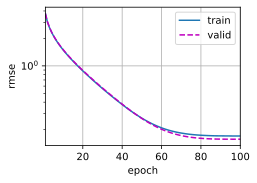

In [11]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)   
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}') 

train log rmse 0.162337


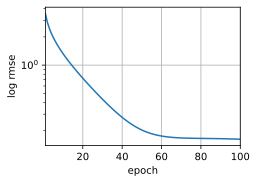

In [12]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)  
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
            ylabel = 'log rmse', xlim=[1,num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.cvs',index = False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)